In this file I attempt to find respecting record in ACMS (input) dataset for each report in output dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
acms_full = pd.read_csv('./data/neo_takeoff_202403260034.csv', parse_dates=['reportts'], low_memory=False) \
    .drop(columns=[
        'processedts', 
    ])

acnum = 'VQ-BGU'
# takeoff_reportname = 'A320 ENGINE TAKE OFF REPORT'
takeoff_reportname = 'A321 ENGINE TAKE OFF REPORT'

acms = acms_full.query(f'acnum=="{acnum}" and reportname=="{takeoff_reportname}"') \
    .drop(columns=['reportname']) \
    .set_index('reportts') \
    .sort_index()

acms.shape

(6816, 205)

In [3]:
egtm_raw = pd.read_csv('./data/EGTM.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'RWCTOMAR': 'egtm'
    }) \
    .loc[:, :'egtm']

egtm_raw['recorded_dt'] = pd.to_datetime(egtm_raw['recorded_dt'], format='%m/%d/%Y %I:%M:%S', errors='raise')

egtm = egtm_raw[(egtm_raw['acnum'] == acnum)]

egtm.head(4)

,acnum,pos,recorded_dt,egtm
2568,VQ-BGU,1,2018-12-24 10:53:22,44.437
2569,VQ-BGU,1,2018-12-25 15:23:23,44.379
2570,VQ-BGU,1,2018-12-25 20:49:27,43.742
2571,VQ-BGU,1,2018-12-26 11:42:26,46.443


In [4]:
n1_raw = pd.read_csv('./data/Data N1.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'EGTM': 'egtm',
        'DELTA N1 (Actual vs Cmd)': 'n1_delt'
    }) \
    .loc[:, :'n1_delt']

n1_raw.shape

(4631, 5)

In [5]:
n2_raw = pd.read_csv('./data/Data N2.csv', parse_dates=['RECORDED_DT']) \
    .drop(columns=['ESN', 'ACC Valve Tprq mtr curr']) \
    .rename(columns={
        'AIRCRAFT': 'acnum',
        'POSITION': 'pos',
        'RECORDED_DT': 'recorded_dt',
        'EGTM': 'egtm',
        'N2 Delt': 'n2_delt'
    }) \
    .loc[:, :'n2_delt']

n2_raw.shape

(4394, 5)

In [6]:
if 'n1_delt' not in egtm.columns:
  egtm = pd.merge(egtm, n1_raw, on=['acnum', 'pos', 'egtm', 'recorded_dt'])
if 'n2_delt' not in egtm.columns:
  egtm = pd.merge(egtm, n2_raw, on=['acnum', 'pos', 'egtm', 'recorded_dt'])
egtm = egtm.set_index('recorded_dt').sort_index()
egtm

,acnum,pos,egtm,n1_delt,n2_delt
recorded_dt,,,,,
2018-12-24 10:53:22,VQ-BGU,1,44.437,-0.110001,-0.341394
2018-12-24 10:53:22,VQ-BGU,2,45.869,-0.090004,-0.214439
2018-12-25 15:23:23,VQ-BGU,1,44.379,-0.070000,-0.356127
2018-12-25 15:23:23,VQ-BGU,2,44.904,-0.070000,-0.230564
2018-12-25 20:49:27,VQ-BGU,1,43.742,-0.049995,-0.379446
...,...,...,...,...,...
2020-02-10 02:04:56,VQ-BGU,1,17.424,-0.030006,-0.563011
2020-02-10 17:24:01,VQ-BGU,2,16.755,-0.059998,-0.524035
2020-02-10 17:24:01,VQ-BGU,1,17.013,-0.080002,-0.666989


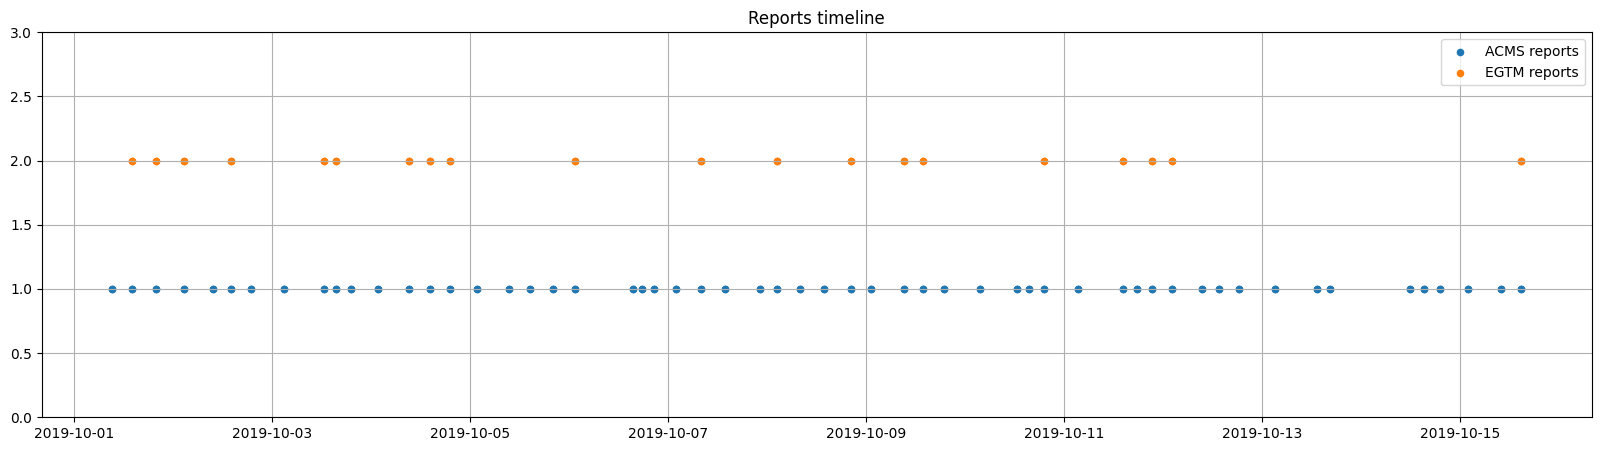

In [7]:
acms_filtered = acms[
    (pd.to_datetime(acms.index).year == 2019) &
    (pd.to_datetime(acms.index).month == 10) &
    (pd.to_datetime(acms.index).day <= 15)  
    # (pd.to_datetime(acms.index).day <= 21)
]

acms_line = acms_filtered.index

egtm_filtered = egtm[
    (pd.to_datetime(egtm.index).year == 2019) &
    (pd.to_datetime(egtm.index).month == 10) & 
    (pd.to_datetime(egtm.index).day <= 15) 
    # (pd.to_datetime(egtm.index).day <= 21) 
]

egtm_line = egtm_filtered.index

fig, ax = plt.subplots(figsize=(20, 5))

ax.scatter(acms_line, y=acms_line.map(lambda _ : 1), s=20)
ax.scatter(egtm_line, y=egtm_line.map(lambda _: 2), s=20)
ax.legend(["ACMS reports", "EGTM reports"])
ax.set_ylim([0, 3])
ax.set_title("Reports timeline")
ax.grid(which='minor', alpha=1)
ax.grid(which='major', alpha=1)
plt.show()

In [8]:
pd.concat([
    pd.Series(acms_line),
    pd.Series(acms_filtered['naiup'].to_numpy(), name='naiup'),
    pd.Series(acms_filtered['pos'].to_numpy()),
    pd.Series(egtm_line),
    pd.Series(egtm_filtered['egtm'].to_numpy(), name='egtm'),
], axis=1)

,reportts,naiup,0,recorded_dt,egtm
0,2019-10-01 09:08:46,120.9,1,2019-10-01 13:52:33,21.667
1,2019-10-01 09:08:46,119.5,2,2019-10-01 13:52:33,22.424
2,2019-10-01 13:52:32,116.7,2,2019-10-01 19:43:33,21.960
3,2019-10-01 13:52:32,116.9,1,2019-10-01 19:43:33,21.257
4,2019-10-01 19:43:33,119.4,1,2019-10-02 02:27:41,21.927
...,...,...,...,...,...
107,2019-10-15 01:47:16,118.3,1,NaT,NaN
108,2019-10-15 09:56:27,117.3,1,NaT,NaN
109,2019-10-15 09:56:27,115.7,2,NaT,NaN
110,2019-10-15 14:48:16,116.4,1,NaT,NaN


Гипотеза: output параметры вычислялись вскоре после записи input параметров 

In [9]:
def merge_by_date(left: pd.DataFrame, right: pd.DataFrame):
  left.sort_values('reportts', inplace=True)
  right.sort_values('reportts', inplace=True)
  right['reportts_'] = right['reportts'] 

  left = left.drop_duplicates('reportts').set_index('reportts')
  right = right.drop_duplicates('reportts').set_index('reportts')

  right_indexed = \
      right.reindex(left.index, method='ffill').reset_index()
  return pd.merge(left, right_indexed, on=['reportts', 'acnum', 'pos'], suffixes=(None, '_'))

def merge_both_engines(left: pd.DataFrame, right: pd.DataFrame, positions = [1, 2]):
  result = []
  
  for pos in positions:
    left_ = left[(left['pos'] == pos)].copy()
    right_ = right[(right['pos'] == pos)].copy()
    merged = merge_by_date(left_, right_)
    result.append(merged)

  return pd.concat(result, ignore_index=True)


merged = merge_both_engines( 
  egtm.reset_index().rename(columns={'recorded_dt': 'reportts'}),
  acms.reset_index()
)

diff = (merged['reportts'] - merged['reportts_']) \
        .astype('timedelta64[s]').astype('int')

merged_sample = merged[diff < 30]


In [15]:
print(merged_sample.shape)

merged_sample.tail(5)

(1672, 210)


,reportts,acnum,pos,egtm,n1_delt,n2_delt,fltdes,dep,arr,pf,...,tr,ttp,vb1,vb2,vorrc,vorv,votm,vsva,w14,reportts_
1770,2020-02-05 05:07:31,VQ-BGU,2,17.670,-0.099998,-0.307325,2508.0,UNNT,UUDD,0.03,...,NaN,47.0,0.1,0.1,56.5,NaN,NaN,0.756,1177.0,2020-02-05 05:07:30
1772,2020-02-09 02:18:44,VQ-BGU,2,17.467,-0.059998,-0.545474,3062.0,UHBB,UUDD,0.03,...,NaN,NaN,0.1,0.2,45.5,NaN,NaN,0.826,1387.0,2020-02-09 02:18:34
1773,2020-02-10 02:04:56,VQ-BGU,2,17.079,-0.040001,-0.313053,3062.0,UHBB,UUDD,0.03,...,NaN,42.0,0.1,0.2,49.6,NaN,NaN,0.797,1325.0,2020-02-10 02:04:55
1774,2020-02-10 17:24:01,VQ-BGU,2,16.755,-0.059998,-0.524035,3061.0,UUDD,UHBB,0.51,...,NaN,NaN,0.1,0.3,48.1,NaN,NaN,0.830,1305.0,2020-02-10 17:23:51
1775,2020-02-11 02:09:38,VQ-BGU,2,16.916,-0.089996,-0.279018,3062.0,UHBB,UUDD,0.51,...,NaN,35.0,0.1,0.1,51.9,NaN,NaN,0.779,1248.0,2020-02-11 02:09:37


Гипотеза верна, и для 1672 записей разница во времени *delta_t = output_t - input_t* составляет не более +30 секунд. Эти записи являются наиболее чистыми данными, которые в дальнейшем я буду использовать для построения baseline-моделей. Есть также небольшая часть данных, для которых delta_t отрицательна. На данный момент эти записи я не включаю в датасет, так как нет уверенности в их корректности. 

Датасет `takeoff-merged-VQ-BGU-30s.csv` будет основным для борта VQ-BGU.

**TODO**: добавить в датасет N1, N2, ETT (?)

**TODO**: аналогичным образом собрать датасет для VQ-BDQ

In [11]:
# merged_sample.drop(columns=['reportts_']) \
#              .to_csv('./takeoff-merged-VQ-BGU-30s-full.csv', index=False)

In [17]:
m = merged_sample
m[(m['reportts'] > '2019-10-19') & (m['reportts'] < '2019-10-22')][
    ['pos', 'reportts_', 'egt', 'reportts', 'egtm']
]

,pos,reportts_,egt,reportts,egtm
733,1,2019-10-20 13:50:44,907.2,2019-10-20 13:50:45,21.292
734,1,2019-10-21 03:40:08,885.9,2019-10-21 03:40:09,21.321
735,1,2019-10-21 11:45:41,947.8,2019-10-21 11:45:42,21.048
736,1,2019-10-21 19:06:36,916.8,2019-10-21 19:06:42,20.711
1621,2,2019-10-20 13:50:44,904.4,2019-10-20 13:50:45,22.413
1622,2,2019-10-21 03:40:08,885.6,2019-10-21 03:40:09,22.380
1623,2,2019-10-21 11:45:41,948.0,2019-10-21 11:45:42,22.057
1624,2,2019-10-21 19:06:36,918.0,2019-10-21 19:06:42,21.749


In [22]:
egtm.reset_index()

,recorded_dt,acnum,pos,egtm,n1_delt,n2_delt
0,2018-12-24 10:53:22,VQ-BGU,1,44.437,-0.110001,-0.341394
1,2018-12-24 10:53:22,VQ-BGU,2,45.869,-0.090004,-0.214439
2,2018-12-25 15:23:23,VQ-BGU,1,44.379,-0.070000,-0.356127
3,2018-12-25 15:23:23,VQ-BGU,2,44.904,-0.070000,-0.230564
4,2018-12-25 20:49:27,VQ-BGU,1,43.742,-0.049995,-0.379446
...,...,...,...,...,...,...
1771,2020-02-10 02:04:56,VQ-BGU,1,17.424,-0.030006,-0.563011
1772,2020-02-10 17:24:01,VQ-BGU,2,16.755,-0.059998,-0.524035
1773,2020-02-10 17:24:01,VQ-BGU,1,17.013,-0.080002,-0.666989
1774,2020-02-11 02:09:38,VQ-BGU,1,17.039,-0.089996,-0.493596


In [74]:
res = []

for pos in [1, 2]:
  egtm_to_merge = egtm \
    .query(f'pos=={pos}') \
    .reset_index().rename(columns={'recorded_dt': 'reportts'}) \
    .set_index('reportts').sort_index() \
    .drop(columns=['acnum', 'pos'])

  m = pd.merge_asof( 
    acms.query(f'pos=={pos}'),
    egtm_to_merge,
    on='reportts',
    direction='nearest',
    tolerance=pd.to_timedelta('30 sec')
  )
  res.append(m)

merged2 = pd.concat(res).dropna(subset=['egtm'])
merged2.shape

(1676, 209)

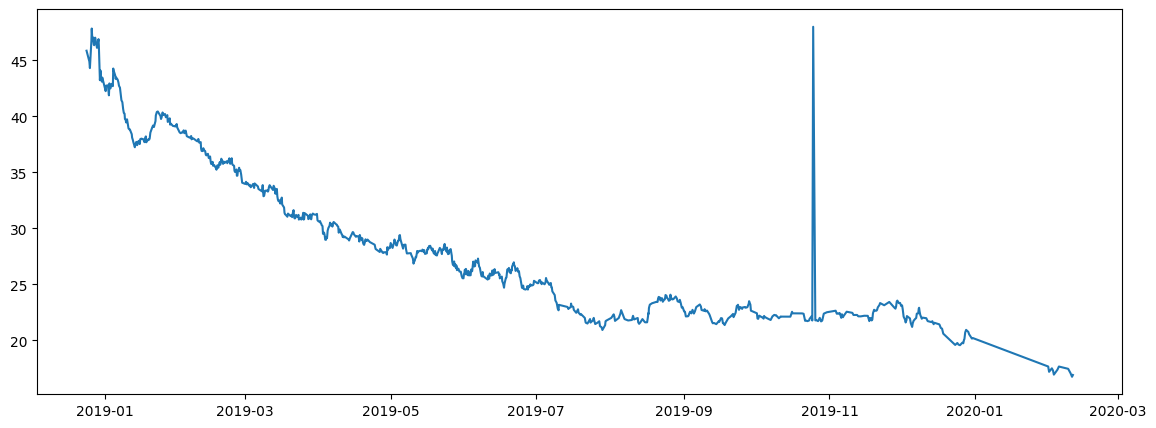

In [76]:
plt.figure(figsize=(14, 5))
m = merged2.query('pos==2 and egtm < 70')
plt.plot(m['reportts'], m['egtm'])
m2 = merged_sample.query('pos==2 and egtm < 45')
# plt.plot(m2['reportts'], m2['egtm'])

In [63]:
merged.shape

(1776, 210)